In [38]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [39]:
# Read the spotify data in from data.csv
url = 'https://media.githubusercontent.com/media/jossharlequin/spotify-popularity-project/main/Resources/sql_spotify_data.csv'
spotify_df = pd.read_csv(url)
spotify_df.head()

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,duration_seconds
0,0.995,0.708,0.1950,0,0.563,10,0.1510,-12.428,1,0,0.0506,118.469,0.7790,158.648
1,0.994,0.379,0.0135,0,0.901,8,0.0763,-28.454,1,0,0.0462,83.972,0.0767,282.133
2,0.604,0.749,0.2200,0,0.000,5,0.1190,-19.924,0,0,0.9290,107.177,0.8800,104.300
3,0.995,0.781,0.1300,0,0.887,1,0.1110,-14.734,0,0,0.0926,108.003,0.7200,180.760
4,0.990,0.210,0.2040,0,0.908,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,687.733


In [42]:
# Binning the data into equal sized groups
labels=[0,1]
q_binned_data = pd.qcut(spotify_df['popularity'], 2, labels=labels, precision=0)

# Getting feature names for determining most important features
feature_names = spotify_df.columns.tolist()
feature_names.remove('popularity')

['acousticness',
 'danceability',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence',
 'duration_seconds']

In [43]:
# Setting popularity as the target variable and setting the remaining columns as features
y = q_binned_data
X = spotify_df.drop(columns='popularity').values

# Splitting training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [44]:
# Scaling the data using StandarScaler as a preprocessing step for the neural network
scaler = StandardScaler()

# Fitting the StandardScaler
X_scaler = scaler.fit(X_train)

# Scaling the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [45]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)

rf_model = rf_model.fit(X_train_scaled, y_train)

In [46]:
# Making predictions using the testing data
import numpy as np
predictions = rf_model.predict(X_test_scaled)

# Rounding predictions into the bins used previously to allow for proper model evaluation
rounded_predictions = np.round(predictions)

# Mapping the rounded predictions to the corresponding labels
mapped_predictions = np.array([0, 1])[np.searchsorted([0, 1], rounded_predictions)]

In [47]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, mapped_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, mapped_predictions)

In [48]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score: {acc_score}")
print("Classification Report")
print(classification_report(y_test, mapped_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,16651,4457
Actual 1,4461,16909


Accuracy Score: 0.7900560290032488
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     21108
           1       0.79      0.79      0.79     21370

    accuracy                           0.79     42478
   macro avg       0.79      0.79      0.79     42478
weighted avg       0.79      0.79      0.79     42478



In [49]:
# Calculating feature importance
importances = rf_model.feature_importances_
# Sorting features by importance
sorted(zip(rf_model.feature_importances_, feature_names), reverse=True)

[(0.30388436644928274, 'acousticness'),
 (0.12514038206440284, 'loudness'),
 (0.0829195560129538, 'duration_seconds'),
 (0.07777659066177967, 'speechiness'),
 (0.0690071462494886, 'valence'),
 (0.06697913788128793, 'danceability'),
 (0.06180384562307912, 'liveness'),
 (0.057896896043027536, 'tempo'),
 (0.0563485815766372, 'energy'),
 (0.0521385795479426, 'instrumentalness'),
 (0.026700653957414805, 'key'),
 (0.013904750861755546, 'explicit'),
 (0.005499513070947652, 'mode')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

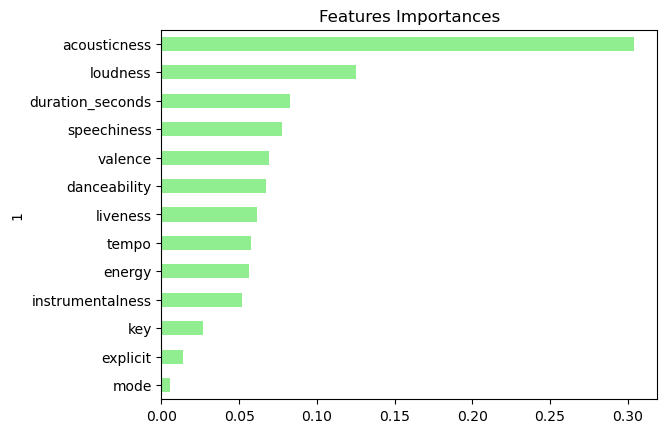

In [50]:
# Visualizing the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, feature_names), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: "Feature Importances"}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= "Features Importances", legend=False)